In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re, string
import unidecode
import numpy as np
import os
import hashlib

from collections import Counter
from textblob import Word
from itertools import combinations, islice

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
# Rex patterns
pattern = re.compile(r'[^A-Za-z0-9À-ÖØ-öø-ÿ ]+')

In [4]:
# Import users data
tas = pd.read_csv("2021-01-01/tas", header=None, sep='\t', names=['user', 'tag', 'content_id', 'content_type', 'date'])

In [5]:
# Define bibtex columns
bibtex_columns = ["content_id","journal","volume","chapter","edition","month","day","booktitle","howPublished","institution","organization","publisher","address","school","series","bibtexKey","url","type","description","annote","note","pages","bKey","number","crossref","misc","bibtexAbstract","simhash0","simhash1","simhash2","entrytype","title","author","editor","year"]

In [6]:
# Import article data
bibtex = pd.read_csv("2021-01-01/bibtex", header=None, sep='\t', names=bibtex_columns, low_memory=False)

In [7]:
# Remove articles without Authors  
bibtex = bibtex.dropna(subset=['content_id'])

In [8]:
# Fix bibtex data types
bibtex = bibtex.astype({'content_id': int})
tas = tas.astype({'content_id': int})

In [9]:
# Fix tags
tas['tag'] = [unidecode.unidecode(str(t)).lower() for t in tas['tag']]
tas['tag'] = [t.replace('-',' ') for t in tas['tag']]
tas['tag'] = [t.replace('_',' ') for t in tas['tag']]
tas['tag'] = [re.sub(r'[^\w\s]', '', t) for t in tas['tag']]
tas['tag'] = [Word(t).singularize() for t in tas['tag']]

In [10]:
# Get tags and sort
tags = tas.groupby('tag').size().sort_values(ascending=False)

In [11]:
# Get user frequency
users = tas.groupby('user').size().sort_values(ascending=False)

In [12]:
# See the most common users
users[1:100]

user
1954647    159594
2463       118606
2977        91196
2840405     84088
2822        71365
            ...  
3875         8451
2017         8401
920          8370
4151         8326
991565       8243
Length: 99, dtype: int64

In [13]:
# Get Journal frequency
journals = bibtex.groupby('journal').size().sort_values(ascending=False)

In [14]:
# See the most common journals
journals[1:100]

journal
Physica A: Statistical and Theoretical Physics                           8078
Physica A: Statistical Mechanics and its Applications                    6921
Economics Letters                                                        6852
International Journal of Trend in Scientific Research and Development    6152
Chaos, Solitons \\& Fractals                                             4727
                                                                         ... 
Journal of Cognitive Neuroscience                                         323
Neural Networks                                                           321
Phys. Rev. D                                                              320
International Journal of Lexicography                                     317
Aus Politik und Zeitgeschichte                                            313
Length: 99, dtype: int64

In [15]:
# Check whether the specified path exists or not
path = 'output'
isExist = os.path.exists(path)

if not isExist:
    # Create a new directory because it does not exist
    os.makedirs(path)

In [16]:
# Export frequency data
tags.to_csv("output/tags.txt")
journals.to_csv("output/journals.txt")

## Select articles from a specific journal

In [17]:
def create_team_networks(journal, keywords):
    articles = bibtex[bibtex.journal == journal]
    
    # Merge tags
    tags_empty = [[] for x in range(len(articles))]
    articles['tags'] = tags_empty
    journal_tags = []

    # Add tags
    for index, article in articles.iterrows():
        # Identify the tags of the article
        article_tag = list(tas[tas.content_id  == article.content_id]['tag'])
        journal_tags += article_tag
        articles.at[index,'tags'] = article_tag
        
    Counter(journal_tags).most_common()
    
    # Identify articles
    network_articles = []
    for key, article in articles.iterrows():
        if any(x in keywords for x in article.tags):
            network_articles.append(article)
    network_articles = pd.DataFrame(network_articles)
    
    # Check number of articles
    print("Number of articles: " + str(len(network_articles)))
    
    # Create the network
    G = nx.Graph()

    # Authors tags
    authors_tags = {}

    # Create the network and extract tags for authors
    for index, article in network_articles.iterrows():
        authors = article.author.split(" and ")
        if len(authors) == 0:
            continue 

        # Identify the tags of the article
        tags = tas[tas.content_id == article.content_id]

        # Fix authors name
        for i in range(0,len(authors)):
            # Invert the names if there is a comma
            if len(authors[i].split(',')) == 2:
                authors[i] = authors[i].split(',')[1].strip() + " " + authors[i].split(',')[0].strip()

            # Remove non-alphanumeric characters
            authors[i] = unidecode.unidecode(pattern.sub('', authors[i])).strip()

            # Replace name for capital
            if len(authors[i].split(' ')) > 1:
                authors[i] = authors[i].split(' ')[0][0] + " " + " ".join(authors[i].split(' ')[1:])

            # Add author to the dictionary
            if authors[i] not in authors_tags:
                authors_tags[authors[i]] = {}

            # Add tags identified
            if len(tags) > 0:
                for j, tag in tags.iterrows():
                    t = unidecode.unidecode(str(tag.tag))

                    if t in ['imported','myown','its','jabrefnokeywordassigned']:
                        continue

                    # Add tag
                    if t not in authors_tags[authors[i]]:
                        authors_tags[authors[i]][t] = 0
                    authors_tags[authors[i]][t] = authors_tags[authors[i]][t] + 1

        # Create the edges among co-authors
        edges = combinations(authors, 2) 
        G.add_edges_from(list(edges))
        
    # Check descriptives
    print("Number of nodes: " + str(G.number_of_nodes()))
    
    # Check descriptives
    print("Number of edges: " + str(G.number_of_edges()))
    
    # Find the largest component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    
    # Check descriptives
    print("Largest component's number of nodes: " + str(G0.number_of_nodes()))

    # Plot graph
    options = {'node_size': 10}
    
    # Plot graph
    nx.draw(G, with_labels=False, font_weight='bold', **options)
    plt.show()
    
    # Get the key dict for the largest component
    G0_authors_tags = { g: authors_tags[g] for g in list(G0.nodes) }
    
    # Check distribution of author tags
    G0_authors_tags_count = [(key, len(x)) for key, x in G0_authors_tags.items()]
    G0_authors_tags_count = sorted(G0_authors_tags_count, key=lambda x: x[1], reverse=True)
    
    # Get the list of tags
    tags_dict = {}
    for key, values in G0_authors_tags.items():
        for value in values:
            if value not in tags_dict:
                tags_dict[value] = 0
            tags_dict[value] = tags_dict[value] + 1
            
    # Sort tags
    tags_dict = dict(sorted(tags_dict.items(), key=lambda item: item[1], reverse=True))
    
    # Check tags
    tags_dict
    
    # Select top-20 tags
    num_skills = min(20, len(tags_dict))
    tags_top = [x[0] for x in list(islice(tags_dict.items(), num_skills))]
    
    # Select authors that have those tags
    selected_authors = [key for key, tags in G0_authors_tags.items() if any(item in tags_top for item in tags.keys())]
    selected_authors = { author: G0_authors_tags[author] for author in selected_authors }

    # Remove other values and set the top tags in each author
    for author, tags in selected_authors.items():
          selected_authors[author] = { tag: tags[tag] if tag in tags.keys() else 0 for tag in tags_top}

    # Create the subgraph with the selected authors
    H = G0.subgraph(selected_authors.keys())
          
    # Check nodes
    print("Number of nodes: " + str(H.number_of_nodes()))

    # Check the number of edges
    print("Number of edges: " + str(H.number_of_edges()))

    # Find the largest component of H
    Hcc = sorted(nx.connected_components(H), key=len, reverse=True)
    H0 = H.subgraph(Hcc[0])

    # Plot configuration
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

    # Check nodes
    print("Largest component's Number of nodes: " + str(H0.number_of_nodes()))

    # Check the number of edges
    print("Largest component's Number of edges: " + str(H0.number_of_edges()))

    # Plot graph
    nx.draw(H0, with_labels=False, font_weight='bold', **options)
    plt.show()

    # Export relationship data
    relationships = nx.to_pandas_edgelist(H0)
    
    relationships.loc[:,"source"] = [hashlib.sha256(x.source.encode('utf-8')).hexdigest()[:10] for k,x in relationships.iterrows()]
    relationships.loc[:,"target"] = [hashlib.sha256(x.target.encode('utf-8')).hexdigest()[:10] for k,x in relationships.iterrows()]
    relationships.to_csv('bibsonomy_'+ journal.split(" ")[0].lower() + '_relationships.csv')

    # Get the key dict for the largest component
    H0_authors_tags = { g: selected_authors[g] for g in list(H0.nodes) }

    # Covert dictionary to a dataframe
    skills = pd.DataFrame.from_dict(H0_authors_tags).T
    skills.columns = ["skill." + str(i) for i in range(1,len(skills.columns)+1)]
    
    # Hex the index
    skills = skills.reset_index()
    skills = skills.rename(columns={"index": "names"})
    skills.loc[:,"names"] = [hashlib.sha256(x.names.encode('utf-8')).hexdigest()[:10] for k,x in skills.iterrows()]
    skills.set_index("names", inplace=True)

    # Export skills data
    skills.to_csv('bibsonomy_'+ journal.split(" ")[0].lower() +'_users_profiles.csv')

## Create datasets

In [18]:
keywords1 = ['network', 'social network', 'socialnetwork', 'small world']
keywords2 = ['network','graph','model','system']

Number of articles: 91
Number of nodes: 155
Number of edges: 712
Largest component's number of nodes: 40


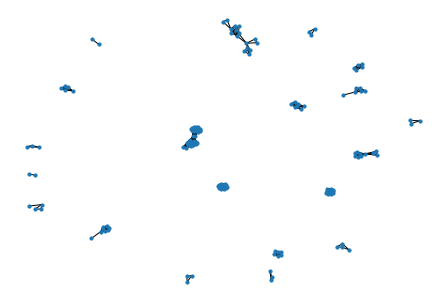

Number of nodes: 40
Number of edges: 398
Largest component's Number of nodes: 40
Largest component's Number of edges: 398


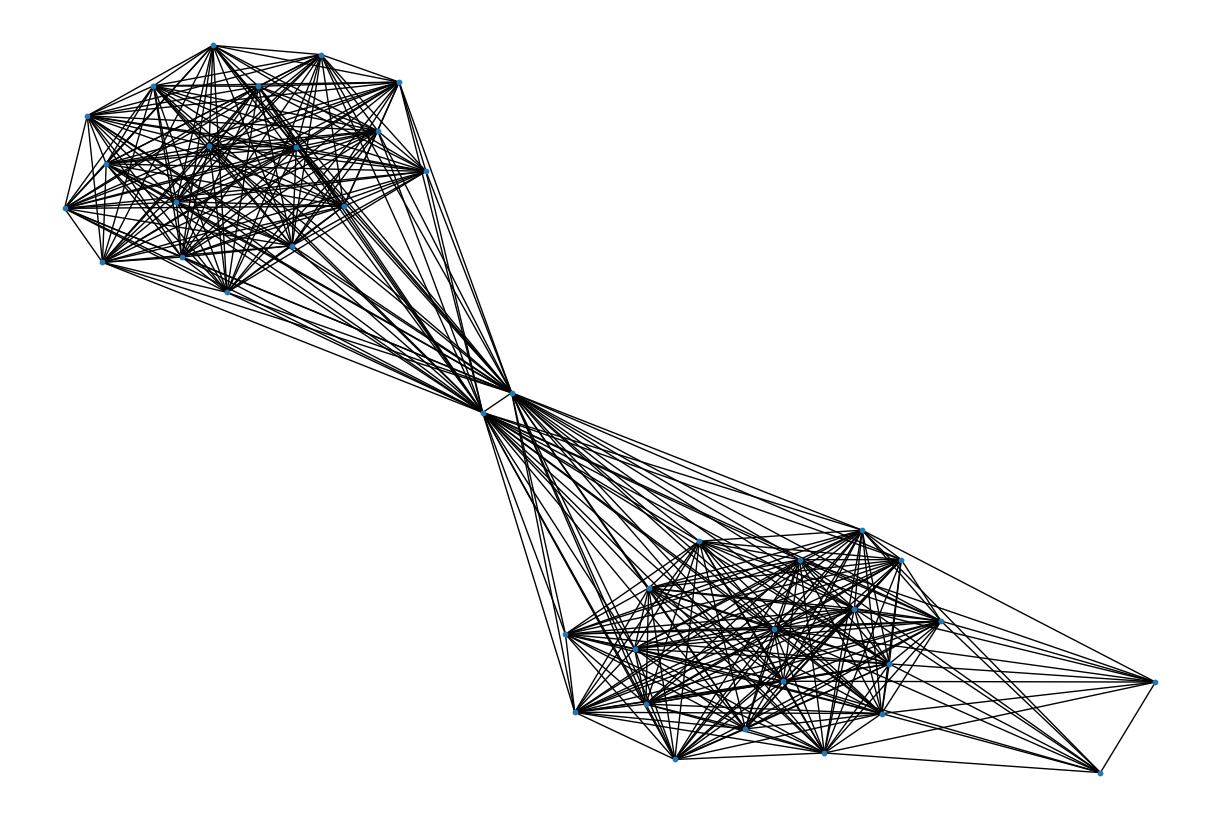

In [19]:
create_team_networks('Nature', keywords1)

Number of articles: 81
Number of nodes: 194
Number of edges: 2582
Largest component's number of nodes: 100


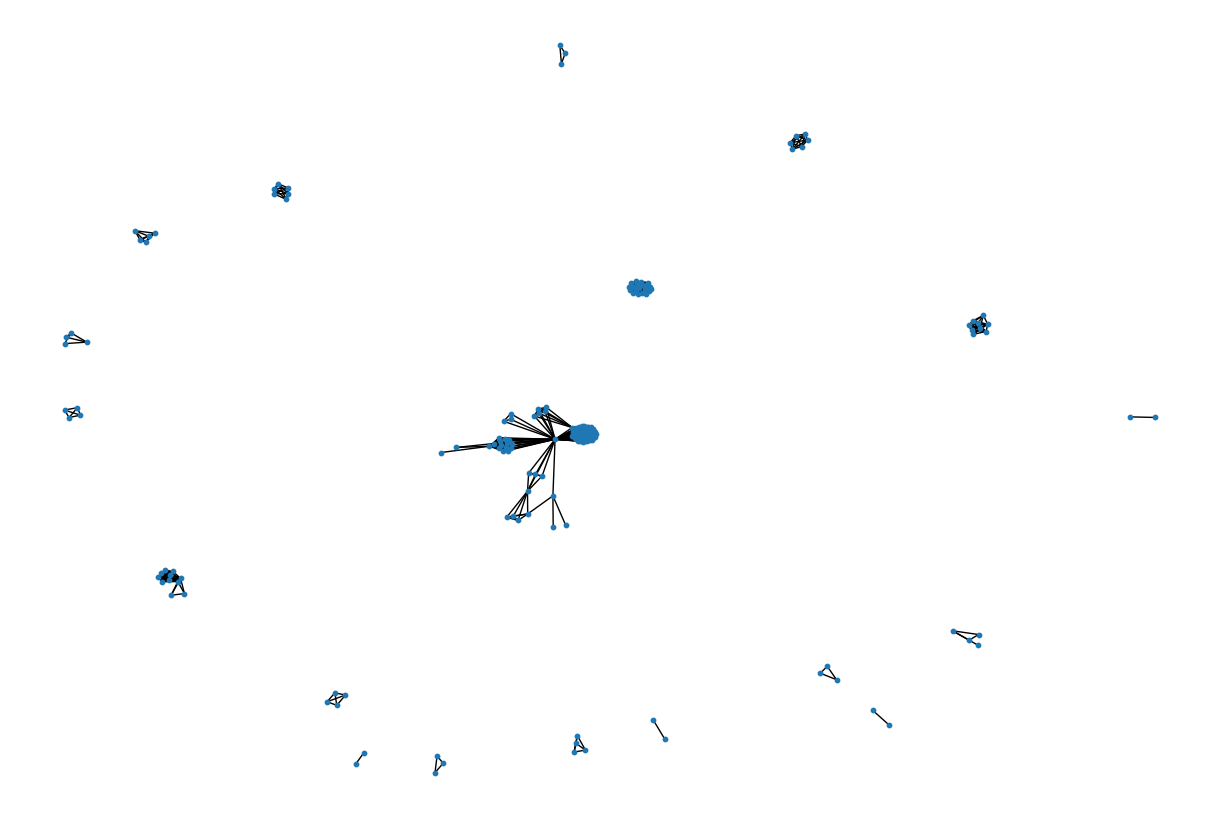

Number of nodes: 100
Number of edges: 2238
Largest component's Number of nodes: 100
Largest component's Number of edges: 2238


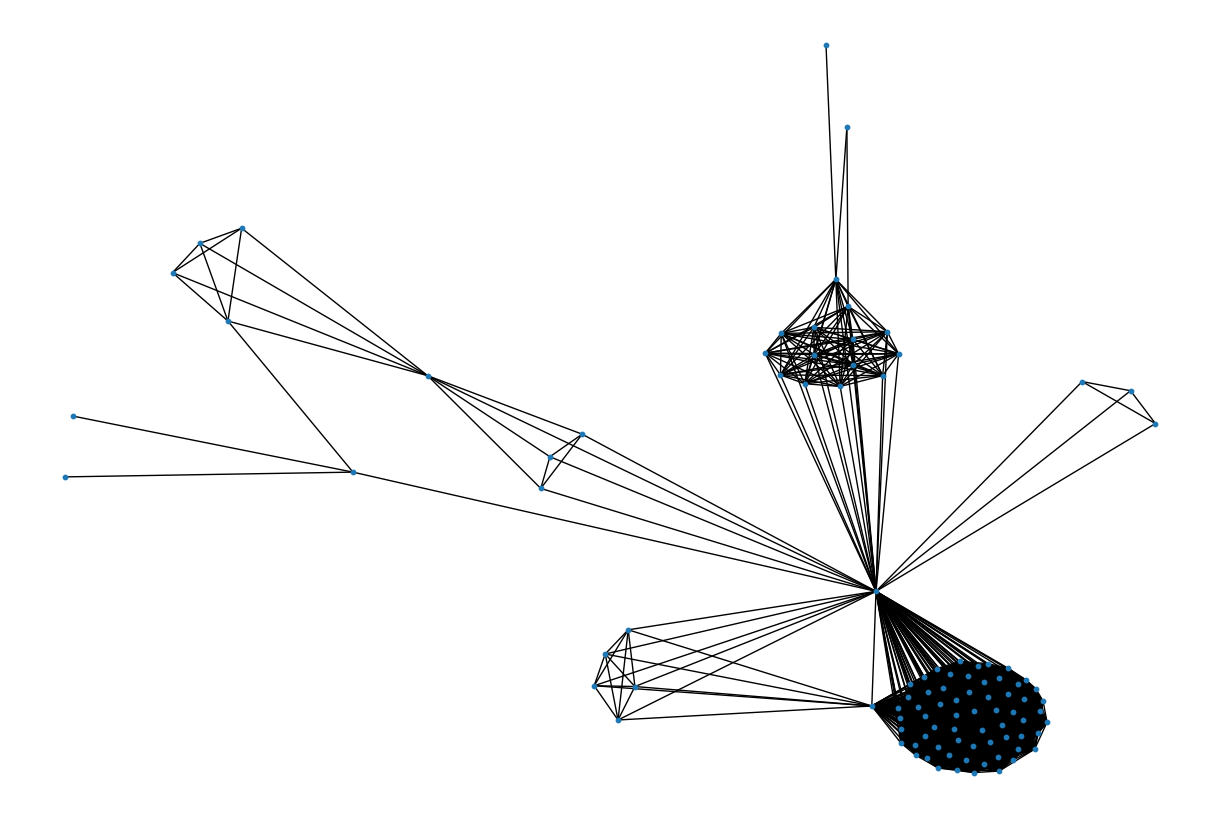

In [20]:
create_team_networks('Science', keywords1)

Number of articles: 854
Number of nodes: 1005
Number of edges: 1456
Largest component's number of nodes: 86


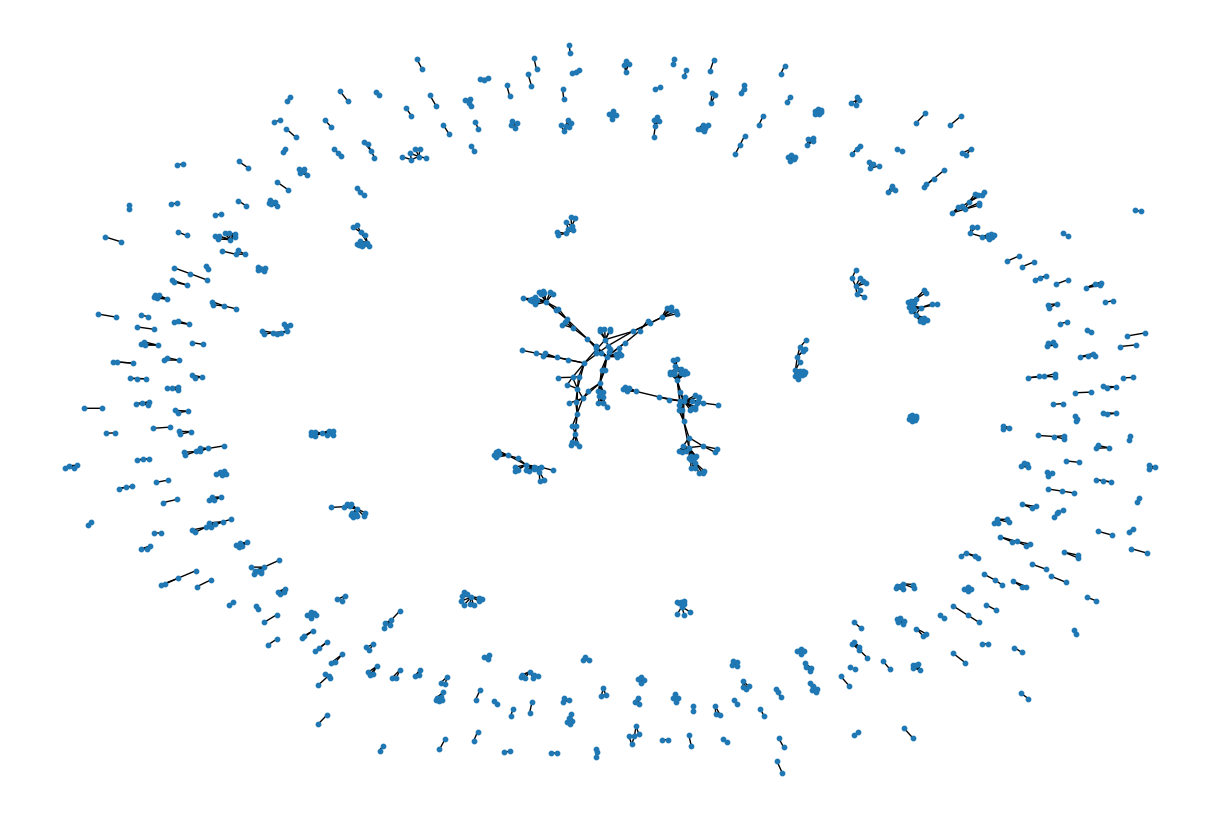

Number of nodes: 86
Number of edges: 160
Largest component's Number of nodes: 86
Largest component's Number of edges: 160


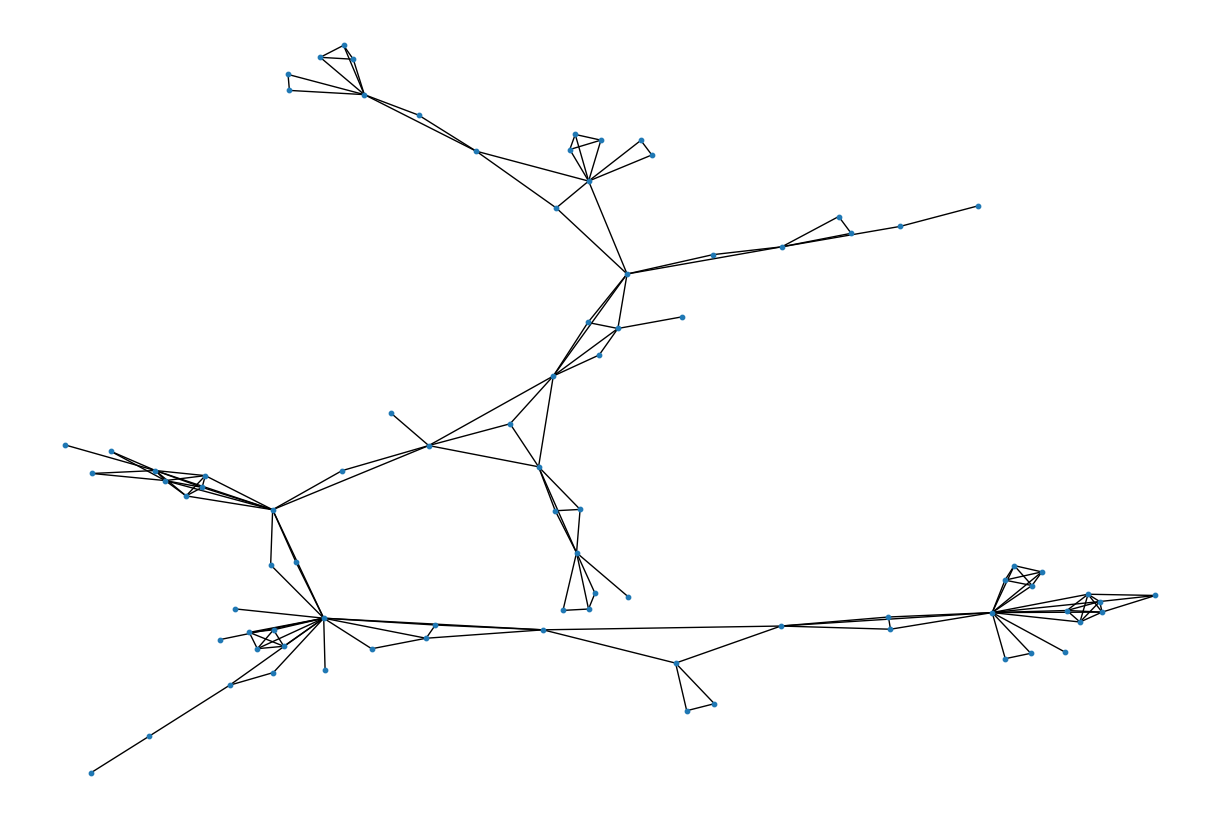

In [21]:
create_team_networks('Physica A: Statistical Mechanics and its Applications', keywords2)